# 构建RAG
* step1.连接一些列PDF文档
* step2.从PDF中格式化出Text,(eg.split into chunks of sentence)，用于Embedding
* step3.Embed所有的text chunks，以存入矢量数据库
* step4.构建retrieval，基于query使用向量搜索 relevant chunks of text
* -------------Document processing and embedding model-----------
* step5.基于检索到的text，生成Prompt
* step6.传入LLM，产生基于query的关于PDF中text知识的LLM回答
* --------------------------RAG System---------------------------

In [1]:
"""
document processing
"""
# 导入PDF Document
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[WARNING]: File {pdf_path} desn't exist, please input url to download...")
    # pdf's url to download
    url = input("url: ")
    
    # 将下载的pdf保存到本地  # [waiting]用os优化目录结构
    filename = pdf_path
    
    # 发送GET请求到URL
    response = requests.get(url=url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[WARNING]: File {url} has been download ，saved as {filename}")
    else:
        print(f"[WARNING]: Failed to download file {url} with status code: {response.status_code}")
    
else:
    print(f"[WARNING]: File {pdf_path} already exist")

[WARNING]: File human-nutrition-text.pdf already exist


In [2]:
# 格式化PDF Document
import fitz
from tqdm.auto import tqdm

def text_format(text: str) -> str:
    """
    自定义 text格式化工具
    """
    cleaned_text = text.replace("\n"," ").strip()
    return cleaned_text

def read_pdf(pdf_path: str) -> list[dict]:
    """
    读取PDF Document中的相关信息，主要包含content和meta source
    """
    docs = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(docs)):
        content = page.get_text()
        content = text_format(content)
        #添加相关数据
        pages_and_texts.append({
            "page_number": page_number, # 从正文开始对齐页码
            "page_char_count": len(content),
            "page_word_count": len(content.split(" ")),
            "page_sentence_count": len(content.split(". ")),
            "page_token_count": len(content)/4, # 1 token ≈ 4characters in english,
            "text": content
        })
    return pages_and_texts

pages_and_texts = read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

E:\My_Anaconda\Anaconda\envs\LangChain_and_VectorDB\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1208it [00:03, 343.10it/s]


[{'page_number': 0,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': 1,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random
random.sample(pages_and_texts, k=1) 

[{'page_number': 661,
  'page_char_count': 1398,
  'page_word_count': 233,
  'page_sentence_count': 17,
  'page_token_count': 349.5,
  'text': 'in calcium absorption. During the first years of menopause,  annual decreases in bone mass range from 3–5 percent. After  age sixty-five, decreases are typically less than 1 percent.7  • Lactose-intolerant people. Groups of people, such as those  who are lactose intolerant, or who adhere to diets that avoid  dairy products, may not have an adequate calcium intake.  • Vegans. Vegans typically absorb reduced amounts of calcium  because their diets favor plant-based foods that contain  oxalates and phytates.8  In addition, because vegans avoid dairy products, their overall  consumption of calcium-rich foods may be less.  If you are lactose intolerant, have a milk allergy, are a vegan, or  you simply do not like dairy products, remember that there are  many plant-based foods that have a good amount of calcium and  there are also some low-lactose an

In [4]:
from spacy.lang.en import English
# load sentencizer pipeline, 智能的sentence划分技巧
nlp = English()
nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This is another sentence? I like dog")

assert len(list(doc.sents)) == 3,"长度不匹配"

type(list(doc.sents)[0])

# list(doc.sents)[2]

spacy.tokens.span.Span

In [5]:
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head(5)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
0,0,29,4,1,7.25,Human Nutrition: 2020 Edition
1,1,0,1,1,0.00,
2,2,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,3,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,4,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [6]:
df.describe().round()  # 根据语料token信息选择适当的embeding模型

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.0,1208.0,1208.0,1208.0,1208.0
mean,604.0,1149.0,199.0,10.0,287.0
std,349.0,560.0,96.0,6.0,140.0
min,0.0,0.0,1.0,1.0,0.0
25%,302.0,763.0,134.0,4.0,191.0
50%,604.0,1232.0,215.0,10.0,308.0
75%,905.0,1605.0,271.0,14.0,401.0
max,1207.0,2308.0,429.0,32.0,577.0


In [7]:
# 将doc中的内容按照sentence进行划分
for page in tqdm(pages_and_texts):
    page["sentences"] = list(nlp(page["text"]).sents)
    # 将sentence转换为str
    page["sentences"] = [str(sents) for sents in page["sentences"]]
    page["page_sentence_count"] = len(page["sentences"])
    
random.sample(pages_and_texts, k=1) 

100%|█████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:05<00:00, 239.65it/s]


[{'page_number': 297,
  'page_char_count': 906,
  'page_word_count': 170,
  'page_sentence_count': 6,
  'page_token_count': 226.5,
  'text': 'The sugar  molecule  deoxyribose  is used to  build the  backbone of  DNA. Image  by rozeta /  CC BY-SA  3.0  Building Macromolecules  Although most absorbed glucose is used to make energy, some  glucose is converted to ribose and deoxyribose, which are essential  building blocks of important macromolecules, such as RNA, DNA,  and ATP. Glucose is additionally utilized to make the molecule  NADPH, which is important for protection against oxidative stress  and is used in many other chemical reactions in the body. If all of the  energy, glycogen-storing capacity, and building needs of the body  are met, excess glucose can be used to make fat. This is why a diet  too high in carbohydrates and calories can add on the fat pounds—a  topic that will be discussed shortly.  Figure 4.11 Chemical Structure of Deoxyribose  Figure 4.12 Double-stranded DNA  25

In [8]:
from pprint import pprint
pprint(pages_and_texts[33])

{'page_char_count': 323,
 'page_number': 33,
 'page_sentence_count': 4,
 'page_token_count': 80.75,
 'page_word_count': 52,
 'sentences': ['Gemady Langfelder  Gemady Langfelder is an undergraduate '
               'dietetics student at the  University of Hawai‘i at Mānoa.',
               'She is an ACSM certified personal  trainer and a novice '
               'horticulturist.',
               'Her interests are nutritional  epidemiology, infant and '
               'pre-/post-natal nutrition, and health  policy.',
               ' xxxiv  |  About the Contributors'],
 'text': 'Gemady Langfelder  Gemady Langfelder is an undergraduate dietetics '
         'student at the  University of Hawai‘i at Mānoa. She is an ACSM '
         'certified personal  trainer and a novice horticulturist. Her '
         'interests are nutritional  epidemiology, infant and pre-/post-natal '
         'nutrition, and health  policy.  xxxiv  |  About the Contributors'}


In [9]:
df = pd.DataFrame(pages_and_texts)
df.describe().round() 

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.0,1208.0,1208.0,1208.0,1208.0
mean,604.0,1149.0,199.0,10.0,287.0
std,349.0,560.0,96.0,6.0,140.0
min,0.0,0.0,1.0,0.0,0.0
25%,302.0,763.0,134.0,5.0,191.0
50%,604.0,1232.0,215.0,10.0,308.0
75%,905.0,1605.0,271.0,15.0,401.0
max,1207.0,2308.0,429.0,28.0,577.0


In [17]:
# split: turn sentences groups into chunks based on specific size
sentences_in_chunk = 10

def splitSens2Chunk(input_sensList: list[str],
                    slice_size: int) -> (list[list[str]],int):
    """
    recursively split sentences into chunks
   eg. input:[21], size:10
       output:[[10],[10],[1]],3
    """
    # [WAITING] add overlap parameter
    result = [input_sensList[i: i + slice_size] for i in range(0, len(input_sensList), slice_size)]
    return result,len(result)

test = list(range(25))
result,num = splitSens2Chunk(test,10)
print(type(result))
type(num)

<class 'list'>


int

In [18]:
"""
split sentences into chunk based on given split_size
"""

for page in tqdm(pages_and_texts):
    page["sentences"], page["chunk_num"] = splitSens2Chunk(page["sentences"],sentences_in_chunk)

100%|██████████████████████████████████████████████████████████████████████████| 1208/1208 [00:00<00:00, 218713.60it/s]


In [20]:
df = pd.DataFrame(pages_and_texts)
df.describe().round() 

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,chunk_num
count,1208.0,1208.0,1208.0,1208.0,1208.0,1208.0
mean,604.0,1149.0,199.0,10.0,287.0,2.0
std,349.0,560.0,96.0,6.0,140.0,1.0
min,0.0,0.0,1.0,0.0,0.0,0.0
25%,302.0,763.0,134.0,5.0,191.0,1.0
50%,604.0,1232.0,215.0,10.0,308.0,1.0
75%,905.0,1605.0,271.0,15.0,401.0,2.0
max,1207.0,2308.0,429.0,28.0,577.0,3.0


In [21]:
pprint(random.sample(pages_and_texts, k=1))

[{'chunk_num': 2,
  'page_char_count': 1665,
  'page_number': 316,
  'page_sentence_count': 11,
  'page_token_count': 416.25,
  'page_word_count': 290,
  'sentences': [['long ingredient lists.',
                 'On the front of food and beverages the  manufacturers may '
                 'include claims such as “sugar-free,” “reduced  sugar,” “high '
                 'fiber,” etc.. The Nutrition and Labeling Act of 1990  has '
                 'defined for the food industry and consumers what these '
                 'labels  mean (Table 4.4 “Food Labels Pertaining to '
                 'Carbohydrates”).',
                 ' Table 4.4 Food Labels Pertaining to Carbohydrates  Label  '
                 'Meaning  Sugar-free  Contains less than 0.5 grams of sugar '
                 'per serving  Reduced  sugar  Contains 25 percent less sugar '
                 'than similar product  Less sugar  Contains 25 percent less '
                 'sugar than similar product, and  was not altered b

In [26]:
"""
将chunks独立为每一个条目，并附加meta source
"""
import re

chunks = []

for page in tqdm(pages_and_texts):
    for sens_chunk in page["sentences"]:
        chunk_dict = {}
        chunk_dict["page_number"] = page["page_number"]
        # chunk中的sentences进行集成，为1个str
        sents_in_chunk = "".join(sens_chunk).replace("  "," ").strip()
        chunk_dict["sentence_chunk"] = sents_in_chunk
        chunk_dict["chunk_char_count"] = len(sents_in_chunk)
        chunk_dict["chunk_word_count"] = len(sents_in_chunk.split(" "))
        chunk_dict["chunk_token_count"] = chunk_dict["chunk_char_count"]/4
        chunks.append(chunk_dict)

100%|███████████████████████████████████████████████████████████████████████████| 1208/1208 [00:00<00:00, 19826.41it/s]


In [27]:
len(chunks)

1843

In [28]:
pprint(random.sample(chunks,k=1))

[{'chunk_char_count': 434,
  'chunk_token_count': 108.5,
  'chunk_word_count': 50,
  'page_number': 1048,
  'sentence_chunk': 'Organic foods are grown or produced without synthetic '
                    'pesticides or fertilizer, and all growers and processors '
                    'must be certified by the US Department of Agriculture '
                    '(USDA).However, conventionally-grown produce 7.\xa0'
                    'Pesticide Residues in Food. (2018).World Health '
                    'Organization.http:/ /www.who.int/mediacentre/ '
                    'factsheets/pesticide-residues-food/en/. Updated January '
                    '2018.Accessed January 28, 2018. The Causes of Food '
                    'Contamination | 1007'}]


{'page_number': 716,
 'sentence_chunk': 'Selenium UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Selenium is a cofactor of enzymes that release active thyroid hormone in cells and therefore low levels can cause similar signs and symptoms as iodine deficiency.The other important function of selenium is as an antioxidant. Selenium Functions and Health Benefits Around twenty-five known proteins require selenium to function. Some are enzymes involved in detoxifying free radicals and include glutathione peroxidases and thioredoxin reductase.As an integral functioning part of these enzymes, selenium aids in the regeneration of glutathione and oxidized vitamin C. Selenium as part of glutathione peroxidase also protects lipids from free radicals, and, in doing so, spares vitamin E. This is just one example of how antioxidants work together to protect the body against free- radical induced damage.Other functions of selenium-containing protein

In [30]:
chunk_df = pd.DataFrame(chunks)
chunk_df.describe()

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.000000,1843.000000,1843.000000,1843.000000
mean,624.381443,731.501356,109.391753,182.875339
std,347.788670,445.541228,69.180205,111.385307
min,0.000000,12.000000,3.000000,3.000000
25%,321.500000,314.000000,43.000000,78.500000
50%,627.000000,745.000000,111.000000,186.250000
75%,931.000000,1112.000000,168.000000,278.000000
max,1207.000000,1824.000000,290.000000,456.000000


In [61]:
"""
根据token量过滤一些信息少或无用的chunk
"""
min_token = 10
rows = chunk_df[chunk_df["chunk_token_count"] <= min_token].sample(2).iterrows()
for row in rows:
    print("\\\\\\\\\\\\\\\\\\\\\\\\\\")
#     print(row)   
#     print("----------------------")
#     print(row[1])
#     print("#########################")
#     print(row[0])
    print(f'{row[1]["chunk_token_count"]}\t {row[1]["sentence_chunk"]} ' )

\\\\\\\\\\\\\
9.25	 Protein’s Functions in the Body | 387 
\\\\\\\\\\\\\
5.25	 Young Adulthood | 907 


In [63]:
# [WAITING] letter into function
chunks_after_filter = chunk_df[chunk_df["chunk_token_count"] >= min_token].to_dict(orient='records')
pprint(chunks_after_filter[0])

{'chunk_char_count': 308,
 'chunk_token_count': 77.0,
 'chunk_word_count': 42,
 'page_number': 2,
 'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT '
                   'MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN '
                   'TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM '
                   'MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, '
                   'JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA '
                   'NICOLE CHUN, AND ALLISON CALABRESE'}


In [66]:
"""
Embedding chunks. eg.embedding model or algorithm like word2vec、custom regulars
"""
from sentence_transformers import SentenceTransformer
embd_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2")

E:\My_Anaconda\Anaconda\envs\LangChain_and_VectorDB\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\20931\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
E:\My_Anaconda\Anaconda\envs\LangChain_and_VectorDB\Lib\site-packages\hug

In [68]:
sentences = ["I like dogs ",
            "she like cats",
            "I drive a car"]
results = embd_model.encode(sentences)
results[0]

array([-1.36108100e-02,  1.15037695e-01, -2.76783425e-02, -4.14817408e-02,
        4.85481806e-02,  3.82316895e-02, -4.50075455e-02, -1.20270336e-02,
       -2.49745115e-03, -1.71299949e-02, -8.12142268e-02,  1.76440980e-02,
       -5.39075062e-02, -1.39213512e-02, -1.78446453e-02, -1.16300527e-02,
        3.81280705e-02,  8.37637782e-02,  1.67845599e-02, -1.06972586e-02,
        3.21551161e-05,  3.07504162e-02, -5.29045835e-02, -3.61079201e-02,
        2.34360062e-02,  3.19114029e-02, -2.55380794e-02, -5.15754446e-02,
        3.55900936e-02,  3.68738212e-02, -5.27857877e-02, -2.98764370e-02,
       -1.24991592e-02, -2.51651723e-02,  1.49855214e-06,  1.84041765e-02,
       -3.83866802e-02,  2.07600985e-02,  6.01903498e-02, -2.36746250e-03,
       -3.24441232e-02, -6.69481084e-02, -3.87305133e-02, -5.49310297e-02,
       -3.28556597e-02,  6.51455000e-02,  6.16199113e-02,  8.87639355e-03,
       -2.27862354e-02,  3.51174474e-02, -2.30697785e-02, -5.32982200e-02,
       -5.27124517e-02,  

In [70]:
results.shape

(3, 768)

In [71]:
%%time
text_chunks = [chunk["sentence_chunk"] for chunk in chunks_after_filter]

CPU times: total: 0 ns
Wall time: 65 ms


In [72]:
text_chunks[1]

'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.'

In [83]:
%%time
for chunk in tqdm(chunks_after_filter):
    chunk["embedding"] = embd_model.encode(chunk["sentence_chunk"])

100%|██████████████████████████████████████████████████████████████████████████████| 1809/1809 [10:07<00:00,  2.98it/s]

CPU times: total: 1h 34min 28s
Wall time: 10min 7s


In [85]:
chunk_embd_df = pd.DataFrame(chunks_after_filter)
chunk_embd_save_path = "chunk_embd.csv"
chunk_embd_df.to_csv(chunk_embd_save_path, index=False)
print(f"Embedding data has been saved at {chunk_embd_save_path}")

Embedding data has been saved at chunk_embd.csv


In [86]:
chunk_embd_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,2,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.067424275, 0.090228036, -0.0050954954, -0.0..."
1,3,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.055215657, 0.059213843, -0.016616788, -0.02..."
2,4,Contents Preface University of Hawai‘i at Māno...,765,113,191.25,"[0.027980154, 0.03398135, -0.020642726, 0.0019..."
3,5,Lifestyles and Nutrition University of Hawai‘i...,940,141,235.00,"[0.06825667, 0.03812743, -0.008468593, -0.0181..."
4,6,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.033026442, -0.008497736, 0.009571517, -0.00..."


In [87]:
chunk_embd_df = pd.read_csv(chunk_embd_save_path)
chunk_embd_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,2,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242750e-02 9.02280360e-02 -5.09549538e-...
1,3,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156568e-02 5.92138432e-02 -1.66167878e-...
2,4,Contents Preface University of Hawai‘i at Māno...,765,113,191.25,[ 2.79801544e-02 3.39813493e-02 -2.06427258e-...
3,5,Lifestyles and Nutrition University of Hawai‘i...,940,141,235.00,[ 6.82566687e-02 3.81274298e-02 -8.46859254e-...
4,6,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264419e-02 -8.49773642e-03 9.57151689e-...


In [89]:
len(chunk_embd_df)  # little dataset (<=100,000) not need to store in vector db

1809

In [3]:
"""
Retrieval System Building. eg.相似度搜索、语义搜索...
"""
#search relevant chunks with query(embeded by same embedding model used for text_chunks)
import random
import numpy as np
import pandas as pd
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

chunks_embd_df = pd.read_csv("chunk_embd.csv")
# chunks_embd_df["embedding"] = chunks_embd_df["embedding"].apply(lambda x: np.fromstring(x))
chunks_embd_df.head(5)

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,2,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242750e-02 9.02280360e-02 -5.09549538e-...
1,3,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156568e-02 5.92138432e-02 -1.66167878e-...
2,4,Contents Preface University of Hawai‘i at Māno...,765,113,191.25,[ 2.79801544e-02 3.39813493e-02 -2.06427258e-...
3,5,Lifestyles and Nutrition University of Hawai‘i...,940,141,235.00,[ 6.82566687e-02 3.81274298e-02 -8.46859254e-...
4,6,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264419e-02 -8.49773642e-03 9.57151689e-...


In [4]:
chunks_embd_df["embedding"] = chunks_embd_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
len(chunks_embd_df["embedding"][0])

768

In [131]:
# chunks_embd_df["embedding"][0]   #pd中存的是str，格式不对，导致后面维度不匹配

array([2.90005926e-057, 6.00050344e-067, 5.34733781e-038, ...,
       1.35653738e-153, 1.42693444e-071, 8.66378237e+140])

In [5]:
chunks_embd = chunks_embd_df.to_dict(orient="records")

In [6]:
embeddings = np.stack(chunks_embd_df["embedding"].to_list(),axis=0)
embeddings.shape

(1809, 768)

In [7]:
# embeddings转换为torch.tensor
embeddings = torch.tensor(embeddings).float()  # 计算相似度时，两个输入类型一致
embeddings.shape

torch.Size([1809, 768])

In [8]:
# 为query使用相同的embedding model
from sentence_transformers import util, SentenceTransformer

query_embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device=device)

E:\My_Anaconda\Anaconda\envs\LangChain_and_VectorDB\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
E:\My_Anaconda\Anaconda\envs\LangChain_and_VectorDB\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


E:\My_Anaconda\Anaconda\envs\LangChain_and_VectorDB\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
"""
build search pipeline
    -- 将query转换为embedding
    -- 确认相似度度量方法 eg.点积、cos相似度
    -- 按序返回relevent chunks
"""
# [WAITING] 将query的token与embd model's input token 比较，防止embedding失败
query = "what's nutrients about vegetable?"
query_embedding = query_embedding_model.encode(query,convert_to_tensor=True) # 可能需要加上.to（“cuda”），让运算的两个tensor在同一个设备上
query_embedding.shape

torch.Size([768])

In [10]:
# compute similarity score(点积：如果数据经过Normalize归一化，长度为1，相当于cos similarity)

from time import perf_counter as timer
start_time = timer()
dot_sim_score = util.dot_score(a=query_embedding, b=embeddings)  # 
end_time = timer()

print(f"[WAENING] Take {end_time-start_time:.3f} seconds to search")
# top_chunks_retrievaled = torch.topk(dot_sim_score,k=3)
# top_chunks_retrievaled
# dot_sim_score[0]
top_chuns_retrievaled = torch.topk(dot_sim_score,k=3)  #查询行向量biggest value和对应indices
top_chuns_retrievaled

[WAENING] Take 0.002 seconds to search


torch.return_types.topk(
values=tensor([[0.5938, 0.5899, 0.5764]]),
indices=tensor([[827,  42, 552]]))

In [12]:
from pprint import pprint
pprint(query_embedding.dtype)
pprint(embeddings.dtype)

torch.float32
torch.float32


In [13]:
chunks_embd[827]

{'page_number': 570,
 'sentence_chunk': '22.00 10.20 Carrots, cooked 1c. 13.00 5.90 Carrots, raw 1 medium 5.10 2.10 Winter squash, baked 1c. 5.70 1.40 Collards, cooked 1c. 11.60 0.20 Tomato 1 medium 0.55 0.10 Tangerine 1 medium 0.13 0.09 Peas, cooked 1c. 1.20 0.09 Source:2010.USDA National Nutrient Database for Standard Reference, Release 23.US Department of Agriculture, Agricultural Fat-Soluble Vitamins | 529',
 'chunk_char_count': 372,
 'chunk_word_count': 56,
 'chunk_token_count': 93.0,
 'embedding': array([-3.96088995e-02, -6.06591143e-02, -1.43779442e-02,  3.16618271e-02,
         1.59537047e-02, -4.73678578e-03, -2.89598554e-02,  2.62598880e-02,
         3.93274315e-02,  2.61996537e-02,  1.55316293e-02,  2.01863293e-02,
         3.77730019e-02,  4.57858741e-02, -3.28798480e-02, -6.75241696e-03,
        -2.18497626e-02,  2.71610753e-03, -6.23964146e-03,  2.19664518e-02,
        -8.27283692e-03,  1.10167805e-02, -2.17985548e-02,  2.30771918e-02,
        -1.16769470e-01,  5.21914512

In [14]:
"""
优化retrievaled chunks，
输出结构清晰
"""
import textwrap

def print_wrapped(text, wrap_length=100):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)


In [15]:
print(f"Query: {query} \n")
print(f"Results:")
for sim_score, idx in zip(top_chuns_retrievaled[0][0],top_chuns_retrievaled[1][0]):
    print(f"Score: {sim_score}")
    print("Text:")
    print_wrapped(chunks_embd[idx]["sentence_chunk"])
    print(f"Page number: {chunks_embd[idx]['page_number']}")
    print("\n\n")
# top_chuns_retrievaled[0][0][0]

Query: what's nutrients about vegetable? 

Results:
Score: 0.5938177704811096
Text:
22.00 10.20 Carrots, cooked 1c. 13.00 5.90 Carrots, raw 1 medium 5.10 2.10 Winter squash, baked 1c.
5.70 1.40 Collards, cooked 1c. 11.60 0.20 Tomato 1 medium 0.55 0.10 Tangerine 1 medium 0.13 0.09
Peas, cooked 1c. 1.20 0.09 Source:2010.USDA National Nutrient Database for Standard Reference,
Release 23.US Department of Agriculture, Agricultural Fat-Soluble Vitamins | 529
Page number: 570



Score: 0.5898747444152832
Text:
Learning Objectives By the end of this chapter, you will be able to: • Describe basic concepts in
nutrition • Describe factors that affect your nutritional needs • Describe the importance of
research and scientific methods to understanding nutrition What are Nutrients? The foods we eat
contain nutrients.Nutrients are substances required by the body to perform its basic
functions.Nutrients must be obtained from our diet, since the human body does not synthesize or
produce them.Nutrients 

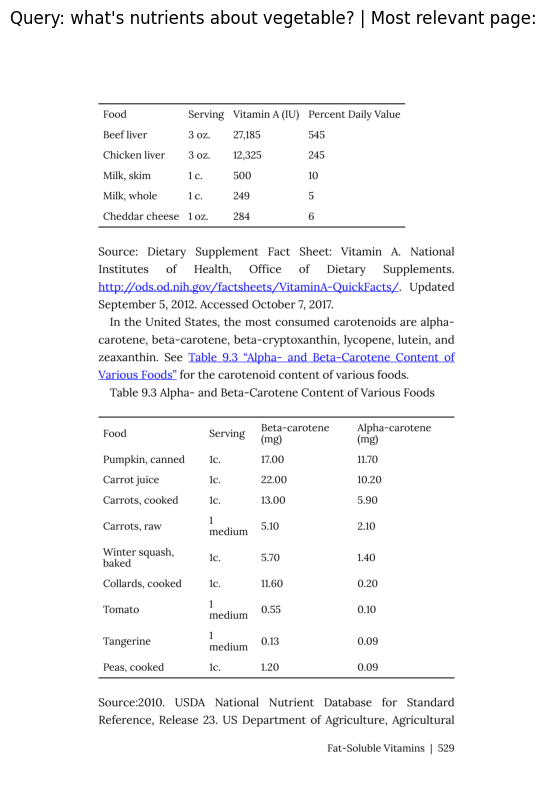

In [206]:
"""
显示查询到的chunk对应的页面
"""
import fitz
real_content_start = 41  #正文前的非正文页数
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(570)

page_img = page.get_pixmap(dpi=300)

# page_img.save("img_save_path.png")

doc.close()
img_array = np.frombuffer(page_img.samples_mv,
                         dtype = np.uint8).reshape(page_img.h, page_img.w, page_img.n)


import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page: ")
plt.axis("off")
plt.show()

In [16]:
"""
计算点积和cos相似度
余弦相似度考虑向量的方向和大小，使其适用于向量的长度与其相似度不直接相关的情况。
当使用点积时只有向量的大小起作用，方向就不那么重要
"""
def similarity(vector1, vector2, mode:str = "dot_product"):
    if mode == "dot_product":
        print(vector1)
        return util.dot_score(vector1, vector2)
    elif mode == "cosine_similarity":
        dot_product = util.dot_score(vector1, vector2)
        norm_vect1 = torch.sqrt(torch.sum(vector1**2))
        norm_vect2 = torch.sqrt(torch.sum(vector2**2))
        cos_sim = dot_product/(norm_vect1 * norm_vect2)
#         return torch.nn.functional.cosine_similarity(vector1,vector2,dim=0) # 注意计算所用维度
        return cos_sim

In [17]:
# 测试
v1 = torch.tensor([1,1]).float()
v2 = torch.tensor([1,1],dtype = torch.float32)
similarity(v1,v2,mode='dot_product')

tensor([1., 1.])


tensor([[2.]])

In [18]:
"""
Integrate into Search Pipeline
"""
def retrieve_relevant_chunks(query: str,
                      embeddings: torch.tensor,
                      embdModel: SentenceTransformer = query_embedding_model,
                      num_of_retrieval: int = 3,  # methord: str,
                      show_time: bool = True):
    
    """
    Embed query with model,return top-k scores and indices from embedding chunks
    """
    query_embedding = query_embedding_model.encode(query, convert_to_tensor=True)
    
    # calculate simliarity
    start_time = timer()
#     sim_score = similarity(query_embedding, embeddingseddings, mode = methord)[0]
    sim_score = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()            
    
    if show_time:
        print(f"[WARING] | {end_time-start_time:.2f} seconds for {len(embeddings)} embeddings.")
    scores, idx = torch.topk(input=sim_score,
                            k=num_of_retrieval)
    return scores, idx

 
def show_top_returnChunks(query: str,
                          embeddings: torch.tensor,                     
                          num_of_retrieval: int = 3,
                          show_time: bool = True):
    """
    打印出检索到的top-k chunks
    """
    scores, indices = retrieve_relevant_chunks(query=query,
                                              embeddings=embeddings,
                                              num_of_retrieval=num_of_retrieval,
                                              show_time=show_time)
    for sim_score, idx in zip(scores, indices):
        print(f"Score: {sim_score}")
        print("Text:")
        print_wrapped(chunks_embd[idx]["sentence_chunk"])
        print(f"Page number: {chunks_embd[idx]['page_number']}")
        print("\n\n")
    

In [19]:
show_top_returnChunks(query="foods high in fiber",embeddings=embeddings,show_time=True)

[WARING] | 0.00 seconds for 1809 embeddings.
Score: 0.6963629722595215
Text:
• Change it up a bit and experience the taste and satisfaction of other whole grains such as barley,
quinoa, and bulgur. • Eat snacks high in fiber, such as almonds, pistachios, raisins, and air-popped
popcorn. Add an artichoke and green peas to your dinner plate more 276 | Carbohydrates and Personal
Diet Choices
Page number: 317



Score: 0.6809899806976318
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers
are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye.Cellulose
and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax,
cauliflower, and avocados.Cellulose is the most abundant fiber in plants, making up the cell walls
and providing structure.Soluble fibers are more easily accessible to bacterial enzymes in the large
intestine so they can be broken down to a greater extent than i

In [ ]:
"""
导入 LLM.   e.g.hugging-face管道导入
通过transformers将hugging-face模型下载到本地
    import torch
    from transformers import AutoTokenizer, AutoModelForCausalLM
    from transformers.utils import is_flash_attn_2_available  #flash_attn2加速推理
    from transformers import BitsAndByteCobnfig
    
    quantization_config = BitsAndByteCobnfig() # 实例化量化配置
    model_id = "   "
    tokenizer = AutoTokenizer.from_pretrained(model_id) # 实例化tokenizer
    llm_model = AutoModelForCausalLM.from_pretrained(model_id,
                                                   quantization_config) # 实例化模型
    llm_model.to("cuda")  # 使用量化配置时，可以放到gpu进行推理运行

    llm_model  # 查看model架构
    
    def cal_model_paramNumber(model: torch.nn.Module):
        # 计算模型参数量
        return sum([param.numel() for param in model.parameters()])
    
    def get_model_mem_size(model: torch.nn.Module):
        # 计算模型内存占用量
        mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
        mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
        #  /(1024 ** 2)转换为MB
        model_mem_bytes = mem_params + mem_buffers
        retur model_mem_bytes

"""
"""
根据RAM MEMORY选择LLM规模 gpu_memory = torch.cuda.get_device_properties(0).total_memory
nvidia-smi
"""

In [20]:
 """
导入本地模型QWEN：7B  -- 千问中文指令微调大模型 
"""
from langchain_community.llms import Ollama
llm = Ollama(model="qwen:7b")

In [250]:
llm.invoke("say something funny in 5 words")

'Why did the tomato turn red? Because it saw the salad dressing!'

In [253]:
"""
create Prompt Template
"""
from langchain.prompts import ChatPromptTemplate
messages = [
    ("system", "You are a comedian who tells jokes about {topic}."),
    ("human", "Tell me {joke_count} jokes."),
]
prompt_template = ChatPromptTemplate.from_messages(messages)
prompt = prompt_template.invoke({"topic": "nutrition", "joke_count": 1})
result = llm.invoke(prompt)
result


"Sure, here's a nutrition-themed joke for you:\n\nWhy did the potato go to the doctor? \n\nBecause it wasn't peeling well!"

In [ ]:
prompt_test = """

Based on the following contexts:
- 
- 
- 
Please answer the following question: who are you?
Answer:
"""

In [21]:
"""
Augument Prompt by adding context which from searched chunks 
"""
def prompt_format(query: str,
                 context_items: list[dict]) -> (str,str):
    context = "- " + "\n- ".join([(item["sentence_chunk"] + "<source> from page: " + str(item["page_number"]) + " <source>") for item in context_items])
    custom_prompt = """Based on the following contexts,plaese answer the query and extract data between <source> into a list and put the list in <source list> location finally.
Context items:
{context}
Query:{query}
Answer:
Source:<source list>
    """
    prompt = custom_prompt.format(context = context,
                                  query = query).strip()
    return prompt,context
query = "tell me some functions about vitamin"
scores, indices = retrieve_relevant_chunks(query=query,
                                          embeddings=embeddings)
context_items = [chunks_embd[idx] for idx in indices]

prompt, reference = prompt_format(query=query,
              context_items=context_items)
pprint(prompt)
pprint("---------------")
pprint(reference)

[WARING] | 0.00 seconds for 1809 embeddings.
('Based on the following contexts,plaese answer the query and extract data '
 'between <source> into a list and put the list in <source list> location '
 'finally.\n'
 'Context items:\n'
 '- Vitamins Major Functions Water-soluble Thiamin (B1) Coenzyme, energy '
 'metabolism assistance Riboflavin (B2 ) Coenzyme, energy metabolism '
 'assistance Niacin (B3) Coenzyme, energy metabolism assistance Pantothenic '
 'acid (B5) Coenzyme, energy metabolism assistance Pyridoxine (B6) Coenzyme, '
 'amino acid synthesis assistance Biotin (B7) Coenzyme, amino acid and fatty '
 'acid metabolism Folate (B9) Coenzyme, essential for growth Cobalamin (B12) '
 'Coenzyme, red blood cell synthesis C (ascorbic acid) Collagen synthesis, '
 'antioxidant Fat-soluble A Vision, reproduction, immune system function D '
 'Bone and teeth health maintenance, immune system function E Antioxidant, '
 'cell membrane protection K Bone and teeth health maintenance, blood clotti

In [22]:
response = llm.invoke(prompt)

In [23]:
pprint(response)

('Here are some major functions of vitamins:\n'
 '\n'
 '1. **Nitrogen Transfer** - Vitamins like thiamine (B1) assist in the '
 'transfer of nitrogen between amino acids, which is crucial for amino acid '
 'synthesis.\n'
 '\n'
 '2. **Red Blood Cell Production** - Vitamin B12 (coenzyme B12) and folate are '
 'vital for the production of red blood cells, which transport oxygen '
 'throughout the body.\n'
 '\n'
 '3. **Synthesis of Bone Tissue** - Vitamin D (cholecalciferol) is crucial for '
 'bone tissue synthesis by promoting calcium absorption in bones.\n'
 '\n'
 '4. **Vision Support** - Vitamin A (retinol) plays a role in maintaining '
 'normal vision by supporting the production of visual pigments.\n'
 '\n'
 '5. **Neurological Function** - Many vitamins, particularly B-complex '
 'vitamins (B1-B6), are essential for proper functioning of the nervous '
 'system.\n'
 '\n'
 'In summary, vitamins play critical roles in various bodily functions, '
 'including amino acid synthesis, red bloo

In [26]:
from rag_evaluator import RAGEvaluator

rag_evaluator = RAGEvaluator()

question = query
response = response
reference = reference

metrics = rag_evaluator.evaluate_all(question, response, reference)

print(metrics)

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
E:\My_Anaconda\Anaconda\envs\LangChain_and_VectorDB\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\20931\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.m

{'BLEU': 2.70442818343797, 'ROUGE-1': 0.379110251450677, 'BERT P': 0.6720286011695862, 'BERT R': 0.6390788555145264, 'BERT F1': 0.6551397442817688, 'Perplexity': 9.123483657836914, 'Diversity': 0.9395973154362416, 'Racial Bias': 0.4926985502243042}


In [27]:
rag_eval_res = {}
rag_eval_res["query"] = query
rag_eval_res["reference"] = reference
rag_eval_res["eval_score"] = metrics

In [28]:
pprint(rag_eval_res)

{'eval_score': {'BERT F1': 0.6551397442817688,
                'BERT P': 0.6720286011695862,
                'BERT R': 0.6390788555145264,
                'BLEU': 2.70442818343797,
                'Diversity': 0.9395973154362416,
                'Perplexity': 9.123483657836914,
                'ROUGE-1': 0.379110251450677,
                'Racial Bias': 0.4926985502243042},
 'query': 'tell me some functions about vitamin',
 'reference': '- Vitamins Major Functions Water-soluble Thiamin (B1) Coenzyme, '
              'energy metabolism assistance Riboflavin (B2 ) Coenzyme, energy '
              'metabolism assistance Niacin (B3) Coenzyme, energy metabolism '
              'assistance Pantothenic acid (B5) Coenzyme, energy metabolism '
              'assistance Pyridoxine (B6) Coenzyme, amino acid synthesis '
              'assistance Biotin (B7) Coenzyme, amino acid and fatty acid '
              'metabolism Folate (B9) Coenzyme, essential for growth Cobalamin '
              '(B12) Co